In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import functools
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import scipy
# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, \
lognormpdf, plot_bivariate_gauss, eval_func_on_grid

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)
#from sklearn import datasets
#from sklearn.preprocessing import LabelBinarizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def banana_logpdf(x):
    xArray = np.array([x[0], x[1]+x[0]**2+1])
    d = 2
    trueCovPost = np.array([[1, 0.9], [0.9, 1]])
    # cov = (2.38/np.sqrt(d))**2*trueCovPost
    cov=trueCovPost
    mu = np.array([0, 0])
    x_mu = xArray-mu
    logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))\
                    *np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))
    return logpdf

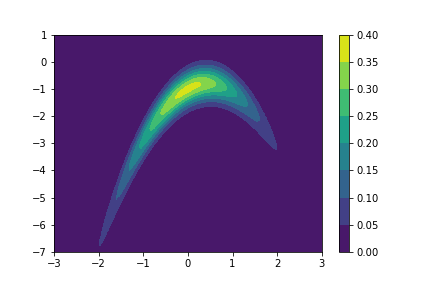

In [6]:
def plot_banana():
    plt.figure()
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-7, 1, 100)
    XX, YY = np.meshgrid(xgrid, ygrid)
    plt.contourf(XX, YY,eval_func_on_grid(compose(np.exp, banana_logpdf)\
                                          ,xgrid, ygrid).T)
    plt.colorbar()
plot_banana()

In [7]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

[[0.56198068 0.45657551]
 [0.45657551 0.55113534]]
[ 1.22939614e-05 -9.99987554e-01]


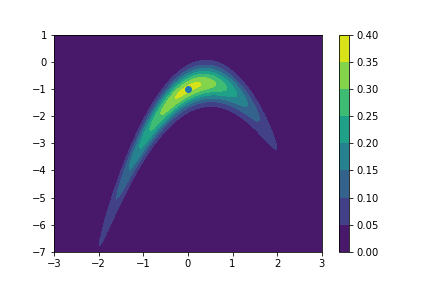

In [8]:
dim = 2
#fig = plt.figure()
guess = np.random.randn((dim)) # random guess
#guess = np.array([1,2])
map_point, cov_laplace = laplace_approx(guess, banana_logpdf)
print(cov_laplace)
print(map_point)
plot_banana()
plt.scatter(map_point[0],map_point[1])
# cov_laplace = np.array([[1.00080451 0.90093851],
#                         [0.90093851 1.00097855]])
# map_point = np.array([-7.66724626e-06 -1.00000697e+00])

In [11]:
class MHMCMC:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
    def sample(self, initial_sample, num_samples):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        
        accept = 1
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] +  np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                self.samples[ii, :] = self.samples[ii-1, :]
                self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
               
            self.num_samples += 1
                
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
                
        return self.samples, accept / float (self.num_samples)

In [12]:
num_samples = 30000
initial_sample = map_point
cov = cov_laplace
mh = MHMCMC(banana_logpdf, cov, t0=300,max_samples=num_samples)

samples, ar = mh.sample(initial_sample, num_samples)

Finished sample 1000, acceptance ratio = 0.406
Finished sample 2000, acceptance ratio = 0.411
Finished sample 3000, acceptance ratio = 0.423
Finished sample 4000, acceptance ratio = 0.42175
Finished sample 5000, acceptance ratio = 0.4158
Finished sample 6000, acceptance ratio = 0.41283333333333333
Finished sample 7000, acceptance ratio = 0.4188571428571429
Finished sample 8000, acceptance ratio = 0.419875
Finished sample 9000, acceptance ratio = 0.423
Finished sample 10000, acceptance ratio = 0.4195
Finished sample 11000, acceptance ratio = 0.4141818181818182
Finished sample 12000, acceptance ratio = 0.4170833333333333
Finished sample 13000, acceptance ratio = 0.4163846153846154
Finished sample 14000, acceptance ratio = 0.4187142857142857
Finished sample 15000, acceptance ratio = 0.423
Finished sample 16000, acceptance ratio = 0.4103125
Finished sample 17000, acceptance ratio = 0.41
Finished sample 18000, acceptance ratio = 0.41388888888888886
Finished sample 19000, acceptance ratio = 

In [13]:
print(ar)

0.42118070602353413


In [14]:
def sub_sample_data(samples, frac_burn=0.2, frac_use=0.7):
    """Subsample data by burning off the front fraction and using another fraction

    Inputs
    ------
    samples: (N, d) array of samples
    frac_burn: fraction < 1, percentage of samples from the front to ignore
    frac_use: percentage of samples to use after burning, uniformly spaced
    """
    nsamples = samples.shape[0]
    inds = np.arange(nsamples, dtype=np.int)
    start = int(frac_burn * nsamples)
    inds = inds[start:]
    nsamples = nsamples - start
    step = int(nsamples / (nsamples * frac_use))
    inds2 = np.arange(0, nsamples, step)
    inds = inds[inds2]
    return samples[inds, :]

In [15]:
samples = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)

/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_10832/3464279978.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inds = np.arange(nsamples, dtype=np.int)


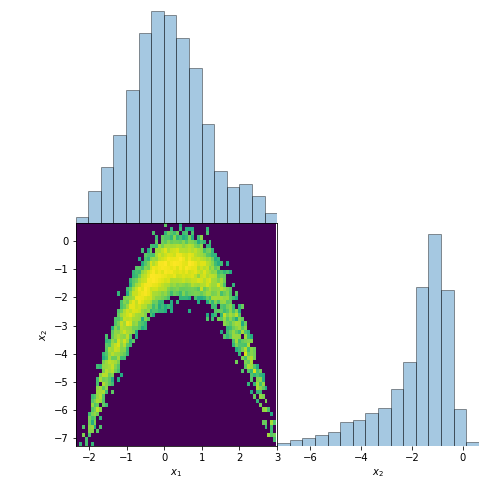

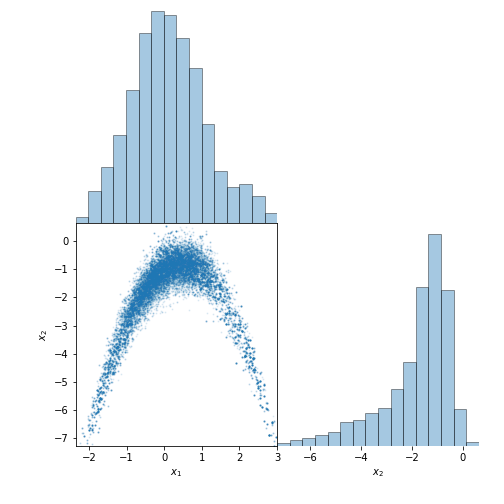

In [17]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.1)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.1,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

In [ ]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + \
            (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

In [ ]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

In [ ]:
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [ ]:
samples_mh=samples

In [ ]:
class AdaptiveMetropolis:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
        self.sample_mean = self.samples[0,:]
        

    def sample(self, initial_sample, num_samples):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        
        accept = 1
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] + \
            np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                self.samples[ii, :] = self.samples[ii-1, :]
                self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
               
            self.num_samples += 1
            
            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:
                sampleMeanNew = (1/(ii+1))*self.samples[ii, :]+(ii/(ii+1))*self.sample_mean
                covUpdate     = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - \
                                (ii+1)*np.dot(sampleMeanNew,sampleMeanNew) + \
                                 np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*covUpdate/ii 
                self.cov_chol = np.linalg.cholesky(self.cov)
                self.sample_mean = sampleMeanNew
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
        return self.samples, accept / float (self.num_samples)

In [ ]:
num_samples = 30000
initial_sample = map_point
cov_g = cov_laplace
am = AdaptiveMetropolis(banana_logpdf, cov_g, sd=None, t0=300, max_samples=num_samples)

samples, ar = am.sample(initial_sample, num_samples)

In [ ]:
print(ar)

In [ ]:
samples = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)

In [ ]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.1)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.1,
                                 nbins=70)
fig.set_size_inches(7,7)

In [ ]:
samples_am=samples

In [ ]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

In [ ]:
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [ ]:
class DelayedRejection:

    def __init__(self, logpdf, cov, t0=100, freq=5, sd=None, max_samples=10000, eps=1e-7):
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
       
    def sample(self, initial_sample, num_samples):
   
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
       
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
       
        accept = 1
        for ii in range(1, num_samples):
           
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
           
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
   
            u = np.random.rand()
           
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                self.num_samples += 1
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                q1 = multiVarLogPDF(y,y2,self.cov)
                q2 = multiVarLogPDF(y,self.samples[ii-1, :],self.cov)
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + q1 - q2)
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
               
            self.num_samples += 1
               
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
               
        return self.samples, accept / float (self.num_samples)

In [ ]:
def multiVarLogPDF(x,y,cov):
    x_mu = x-y
    logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))\
                    *np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))
    return logpdf

In [ ]:
num_samples = 30000
initial_sample = map_point
cov = cov_laplace
# initial_sample = np.array([0, 1])
# cov = np.array([[1, 0.9],[0.9, 1]])
dr = DelayedRejection(banana_logpdf, cov,t0=300,max_samples=num_samples)
samples, ar = dr.sample(initial_sample,num_samples)

In [ ]:
print(ar)

In [ ]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.1)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.1,
                                 nbins=70)
fig.set_size_inches(7,7)

In [ ]:
samples = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)

In [ ]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.1)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.1,
                                 nbins=70)
fig.set_size_inches(7,7)

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [ ]:
samples_dr=samples

In [ ]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

In [ ]:
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)

In [ ]:
class DelayedRejectionAdaptiveMetropolis:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
        self.sample_mean = self.samples[0,:]
        
    def sample(self, initial_sample, num_samples):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        
        accept = 1
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
        
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
#                 self.num_samples += 1
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                q1 = multiVarLogPDF(y,y2,self.cov)
                q2 = multiVarLogPDF(y,self.samples[ii-1, :],self.cov)
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + q1 - q2)
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            self.num_samples += 1
             
            
            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:
                sampleMeanNew = (1/(ii+1))*self.samples[ii, :]+(ii/(ii+1))*self.sample_mean
                covUpdate     = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - \
                                (ii+1)*np.dot(sampleMeanNew,sampleMeanNew) + \
                                 np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*covUpdate/ii 
                self.cov_chol = np.linalg.cholesky(self.cov)
                self.sample_mean = sampleMeanNew           
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
                
        return self.samples, accept / float (self.num_samples)

In [ ]:
num_samples = 30000
initial_sample = map_point
cov = cov_laplace
# initial_sample = np.array([0, 1])
# cov = np.array([[1, 0.9],[0.9, 1]])
dram = DelayedRejectionAdaptiveMetropolis(banana_logpdf, cov, freq=5,
                                          t0=300, sd = None, eps = 1e-7, max_samples=num_samples)
samples, ar = dram.sample(initial_sample,num_samples)

In [ ]:
print(ar)

In [ ]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.1)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.1,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

In [ ]:
samples = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)

In [ ]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

In [ ]:
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [ ]:
samples_dram=samples

In [ ]:
maxlag=500
step=1
lags_MH, autolag_MH = autocorrelation(samples_mh, maxlag=maxlag,step=step)
lags_AM, autolag_AM = autocorrelation(samples_am, maxlag=maxlag,step=step)
lags_AM, autolag_DR = autocorrelation(samples_dr, maxlag=maxlag,step=step)
lags_AM, autolag_DRAM = autocorrelation(samples_dram, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag_MH[:, 0],'-o',label='MH')
axs[0].plot(lags, autolag_AM[:, 0],'-o',label='AM')
axs[0].plot(lags, autolag_DR[:, 0],'-o',label='DR')
axs[0].plot(lags, autolag_DRAM[:, 0],'-o',label='DRAM')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag_MH[:, 1],'-o',label='MH')
axs[1].plot(lags, autolag_AM[:, 1],'-o',label='AM')
axs[1].plot(lags, autolag_DR[:, 1],'-o',label='DR')
axs[1].plot(lags, autolag_DRAM[:, 1],'-o',label='DRAM')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.legend()
plt.show()